## Required packages

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

from scipy.optimize import linprog

## Data center user-defined inputs

In [2]:
### Table 1 in the CISBAT Paper
PPP = 0.4 # the fraction of flexible workload (expected value)
KKK = 9   # contract time limits (expected value)
III = 0.6 # safety factor (expected value)

### 1. Data center power vs workload level

In [3]:
SPEC = pd.read_excel("Data/data.xlsx",sheet_name="data") # Performance to Power Ratio

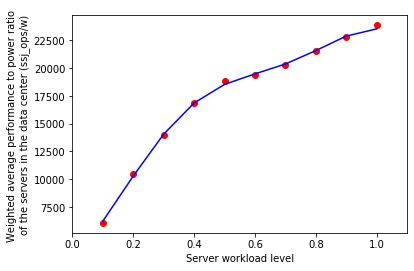

In [4]:
SPEC_X=np.array(SPEC.Load.values).reshape(10,1)
SPEC_Y=np.array(SPEC["Performance to Power Ratio"].values).reshape(10,1)

# fit a gp for data center 'Performance to Power Ratio'
kernel = ConstantKernel(1.0, (1e-4, 1e3)) * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=20).fit(SPEC_X,SPEC_Y)
# visualize
SPEC_Y_pred = gp.predict(SPEC_X, return_std=False)

plt.scatter(SPEC_X,SPEC_Y,color="red")
plt.plot(SPEC_X,SPEC_Y_pred,color="blue",linewidth=1.5)
plt.xlim([0,1.1])
plt.xlabel('Server workload level')
plt.ylabel('Weighted average performance to power ratio \nof the servers in the data center (ssj_ops/w)')
plt.show()

### 2. Data center capacity, real-time loads

In [5]:
capacity_Max = 100 # 100MW, https://energyinnovation.org/2020/03/17/how-much-energy-do-data-centers-really-use/
throughput_Max = capacity_Max*10**6/SPEC.Power[0]*SPEC.ssj_ops[0] # ssj_ops/s
allowable_ul = III # allowable workload level
throughput_allow_hour = throughput_Max*3600*allowable_ul # ssj_ops/h: allowable workloads per hour (upper load constraint)

In [6]:
# user-defined load-curve acorss time
DC_profile = pd.read_excel("Data/data.xlsx",sheet_name="load shape")
DC_profile['Load'] = throughput_Max*DC_profile.Load_level.values

# flexiable loads & unflexiable loads
flex_p = PPP  # mean flexiable loads percentage overtime
np.random.seed(20)
flex_p = np.random.normal(flex_p, 0.2, 24)
flex_p = np.array([0 if flex_p[i] <=0 else flex_p[i] for i in range(len(flex_p))])
flex_p = np.array([1 if flex_p[i] >=1 else flex_p[i] for i in range(len(flex_p))])

DC_profile['Flexload'] = flex_p * DC_profile.Load
DC_profile['Nonflexload'] = (1-flex_p) * DC_profile.Load

### 3. Data center PUE, WUE

In [7]:
UE = pd.read_excel("Data/PUE_WUE.xlsx")
UE = UE[(UE.Month==6)&((UE.Day==2) | (UE.Day==3))]
PUE = UE.PUE.values
WUE = UE.WUE.values

### 4. Electricity emissions vs water footprint

In [8]:
# mTCO2/h
co2_1 = pd.read_csv("Data/CAISO-co2-20200602.csv",index_col=0)
co2_1 = co2_1.values[0]
co2_1 = np.array([np.mean(co2_1[12*i:12*(i+1)]) for i in range(24)])

co2_2 = pd.read_csv("Data/CAISO-co2-20200603.csv",index_col=0)
co2_2 = co2_2.values[0]
co2_2 = np.array([np.mean(co2_2[12*i:12*(i+1)]) for i in range(24)])

In [9]:
# MW
MW_1 = pd.read_csv("Data/CAISO-supply-20200602.csv",index_col=0)
MW_1 = MW_1.sum(axis=0).values
MW_1 = np.array([np.mean(MW_1[12*i:12*(i+1)]) for i in range(24)])

MW_2 = pd.read_csv("Data/CAISO-supply-20200603.csv",index_col=0)
MW_2 = MW_2.sum(axis=0).values
MW_2 = np.array([np.mean(MW_2[12*i:12*(i+1)]) for i in range(24)])

In [10]:
# mTCO2e/MWh = kgC02e/kWh
co2_intensity_1 = co2_1/MW_1
co2_intensity_2 = co2_2/MW_2
co2_intensity = np.concatenate((co2_intensity_1,co2_intensity_2))

In [11]:
electricity = pd.read_excel("Data/data.xlsx",sheet_name="WF",header=None,index_col=0).values
electricity = electricity/np.sum(electricity,axis=0)

In [12]:
wf = np.array([0.091,0.008,8.750,2.325,1.080,1.575,1.825,7.700]).reshape(8,1)
electricity_wf = np.sum(electricity*wf,axis=0)
electricity_wf = np.array([np.mean(electricity_wf[12*i:12*(i+1)]) for i in range(48)])

### 5. Electricity & water price

In [13]:
# dollars per MWh
electric_rate = pd.read_excel("Data/data.xlsx",sheet_name="electric rate",index_col=0).values.T[0]

In [14]:
# water price
water_rate = np.array([3.54,3.92,4.74,6.15,6.24]) # dollors per kGal
water_rate = np.mean(water_rate)/3785 #dollors per litter

### 6. Other constraints

In [15]:
# maximum allowable time to execute the flexiable loads (changing with constomer requirement)
np.random.seed(50)
max_hour = np.random.normal(KKK, 3, 48).astype(np.int)

In [16]:
# 
Load_f = np.tile(DC_profile.Flexload.values*3600,2)
Load_nf = np.tile(DC_profile.Nonflexload.values*3600,2)
elec_rate = np.tile(electric_rate,2)/1000 #$/kWh

# Optimization

# Multi-objective optimization

In [17]:
load_shifed = np.zeros((48,48))

for k in range(24):
    print(k)
    n = max_hour[k] + 1
    
    pred_ssjops = gp.predict([[0.25]], return_std=False)[0][0] # expectation of the server workload level at time t: 0.25
    
    c1 = np.array((PUE[0+k:n+k] * elec_rate[0+k:n+k] + WUE[0+k:n+k] * water_rate)/pred_ssjops) # electricity& water rate
    c2 = np.array(PUE[0+k:n+k] * co2_intensity[0+k:n+k]/pred_ssjops) # co2
    c3 = np.array((electricity_wf[0+k:n+k] * PUE[0+k:n+k] + WUE[0+k:n+k])/pred_ssjops) # wf
    
    A_eq = np.array([[1]*n])
    b_eq = np.array([Load_f[k]])
    
    # upper bound
    ub = throughput_allow_hour - np.sum(load_shifed,axis=0)[0+k:n+k]
    bounds = [(0,ub[i]) for i in range(n)]
    
    # multi-objective
    pareto_x = np.array([]).reshape(0,n)
    pareto_y = np.array([]).reshape(0,3)
    np.random.seed(20)
    v = np.random.dirichlet(np.ones(3),size=200)
    for w in v:
        c = w[0]*c1 + w[1]*c2 + w[2]*c3
        x = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds).x.reshape(1,n)
        y = np.array([np.dot(x,c1)/1000/3600,np.dot(x,c2)/1000/3600,np.dot(x,c3)/1000/3600]).reshape(1,3)
        pareto_x = np.vstack((pareto_x,x))
        pareto_y = np.vstack((pareto_y,y))
        
    load_shifed[k,0+k:n+k] = pareto_x[np.argmin(pareto_y[:,1])] # change index here:
    # pareto_y[:,0]--minimal OPEX in the pareto set ; 
    # pareto_y[:,1]--minimal CEs in the pareto set; 
    # pareto_y[:,2]--minimal WF in the pareto set. 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


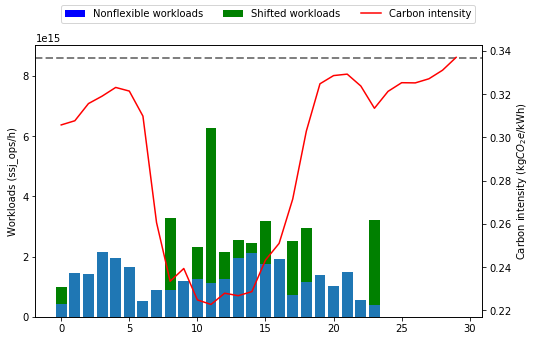

In [18]:
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.bar(np.arange(24),Load_nf[0:24])
ax1.bar(np.arange(24),np.sum(load_shifed,axis=0)[0:24],bottom=Load_nf[0:24],color="blue",label='Nonflexible workloads')

ax1.bar(np.arange(24),np.sum(load_shifed,axis=0)[0:24],bottom=Load_nf[0:24],color="green",label='Shifted workloads')

ax1.bar(np.arange(48)[24:30],np.sum(load_shifed,axis=0)[24:30],color="green")

ax1.set_ylabel("Workloads (ssj_ops/h)")

ax1.axhline(y=throughput_Max*3600,linestyle="--",linewidth=2,color="grey")

ax2 = ax1.twinx()
#ax2.plot(np.arange(48)[0:30],elec_rate[0:30],color="red",label='Electricity rate')
#ax2.set_ylabel("Electricity rate")

ax2.plot(np.arange(48)[0:30],co2_intensity[0:30],color='red',label='Carbon intensity')
ax2.set_ylabel("Carbon intensity (kg$CO_2e$/kWh)")

#ax2.plot(np.arange(48)[0:30],electricity_wf[0:30],color="red",label='water footprint')
#ax2.set_ylabel("water footprint")

fig.legend(loc="upper center",ncol=3)
plt.show()